In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 导入数据

In [23]:
ChinaBank = pd.read_csv('ChinaBank.csv',index_col = 'Date',parse_dates=['Date'])

ChinaBank.head()

,Unnamed: 0,Open,High,Low,Close,Volume
Date,,,,,,
2014-01-02,1,2.62,2.62,2.59,2.61,41632500
2014-01-03,2,2.60,2.61,2.56,2.56,45517700
2014-01-06,3,2.57,2.57,2.50,2.53,68674700
2014-01-07,4,2.51,2.52,2.49,2.52,53293800
2014-01-08,5,2.51,2.54,2.49,2.51,69087900


# 提取Close列

In [24]:
ChinaBank.index = pd.to_datetime(ChinaBank.index)
sub = ChinaBank.loc['2014-01':'2014-06','Close']

sub.head()

Date
2014-01-02    2.61
2014-01-03    2.56
2014-01-06    2.53
2014-01-07    2.52
2014-01-08    2.51
Name: Close, dtype: float64

# 划分训练测试集

In [25]:
train = sub.loc['2014-01':'2014-03']
test = sub.loc['2014-04':'2014-06']

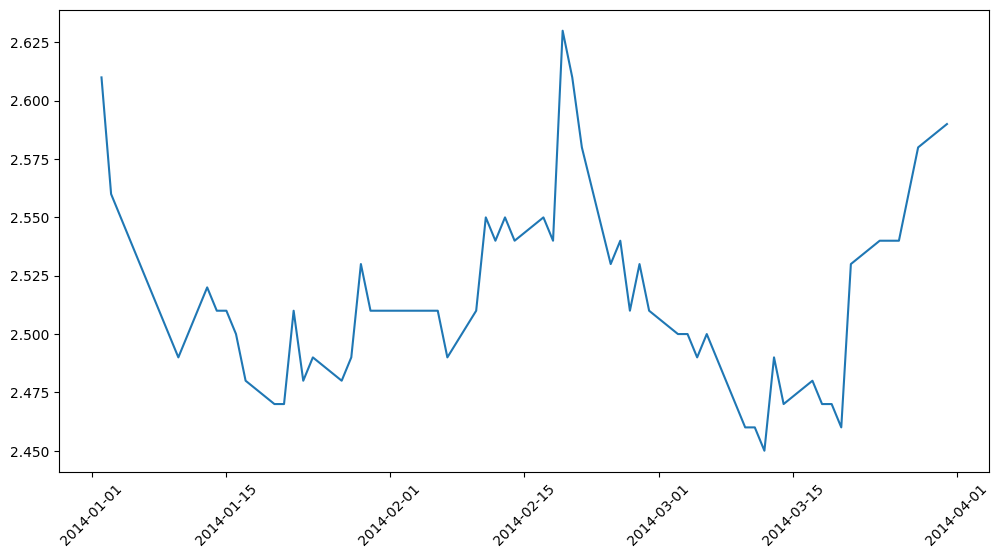

In [26]:
#查看训练集的时间序列与数据(只包含训练集)
plt.figure(figsize=(12,6))
plt.plot(train)
plt.xticks(rotation=45) #旋转45度
plt.show()

# 差分法

In [27]:
#.diff(1)做一个时间间隔
ChinaBank['diff_1'] = ChinaBank['Close'].diff(1) #1阶差分

#对一阶差分数据在划分时间间隔
ChinaBank['diff_2'] = ChinaBank['diff_1'].diff(1) #2阶差分

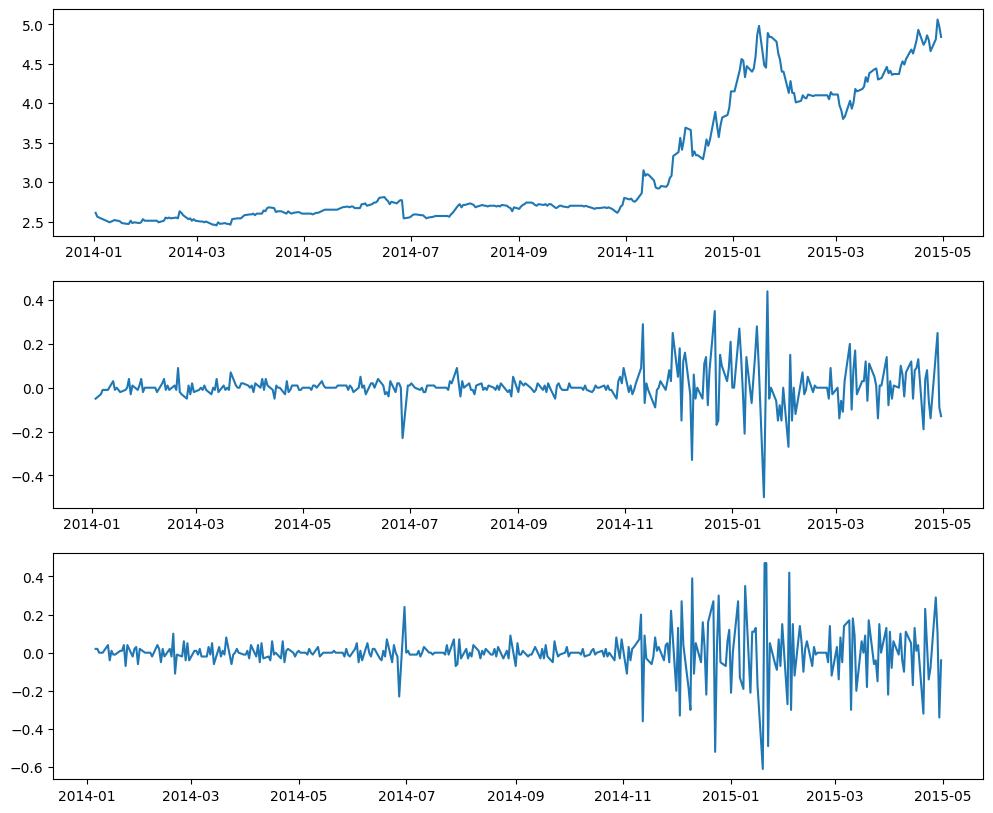

In [28]:
fig = plt.figure(figsize=(12,10))
#原数据
ax1 = fig.add_subplot(311)
ax1.plot(ChinaBank['Close'])
#1阶差分
ax2 = fig.add_subplot(312)
ax2.plot(ChinaBank['diff_1'])
#2阶差分
ax3 = fig.add_subplot(313)
ax3.plot(ChinaBank['diff_2'])
plt.show()

# ADF检验

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

# 计算原始序列、一阶差分序列、二阶差分序列的单位根检验结果
ChinaBank['diff_1'] = ChinaBank['diff_1'].fillna(0)
ChinaBank['diff_2'] = ChinaBank['diff_2'].fillna(0)

timeseries_adf = ADF(ChinaBank['Close'].tolist())
timeseries_diff1_adf = ADF(ChinaBank['diff_1'].tolist())
timeseries_diff2_adf = ADF(ChinaBank['diff_2'].tolist())


# 打印单位根检验结果
print('timeseries_adf : ', timeseries_adf)
print('timeseries_diff1_adf : ', timeseries_diff1_adf)
print('timeseries_diff2_adf : ', timeseries_diff2_adf)


timeseries_adf :  (0.5279198084831841, 0.9856974415734417, 9, 335, {'1%': -3.4500219858626227, '5%': -2.870206553997666, '10%': -2.571387268879483}, -734.0738716811488)
timeseries_diff1_adf :  (-6.177185544978992, 6.587109239761615e-08, 8, 336, {'1%': -3.449962981927952, '5%': -2.870180642420163, '10%': -2.5713734527352607}, -735.8436797171294)
timeseries_diff2_adf :  (-9.20254512316034, 1.9841232339616833e-15, 13, 331, {'1%': -3.4502615951739393, '5%': -2.8703117734117742, '10%': -2.5714433728242714}, -717.2833732193096)


# 参数确定

In [30]:
import statsmodels.api as sm

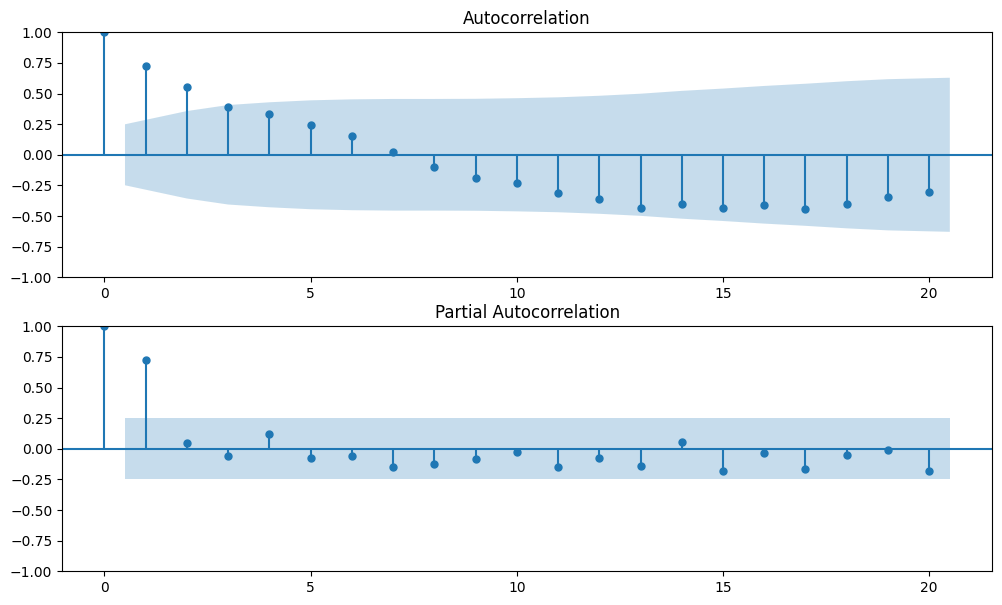

In [31]:
#绘制
fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom') # 设置坐标轴上的数字显示的位置，top:显示在顶部  bottom:显示在底部
#fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
#fig.tight_layout()
plt.show()

# 模型建立

In [32]:
#遍历，寻找适宜的参数
import itertools
import numpy as np
import seaborn as sns

In [33]:
#确定pq的取值范围
p_min = 0
d_min = 0
q_min = 0
p_max = 5
d_max = 0
q_max = 5

In [34]:
#Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue

d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Python311\Lib\site-package

In [35]:
results_bic

,MA0,MA1,MA2,MA3,MA4,MA5
AR0,NaN,-245.656321,-263.526431,-261.821299,-262.685194,-258.6142
AR1,-274.893562,-270.800469,-267.689004,-264.563398,-258.673601,-253.343236
AR2,-270.811645,-269.200854,-265.435165,-259.567044,-259.172598,-258.641864
AR3,-267.781626,-265.338891,-260.366622,-257.30172,-261.009517,-260.797313
AR4,-264.968235,-261.358466,-256.994387,-253.197748,-258.075512,-252.258825
AR5,-261.882452,-257.385419,-252.104888,-248.986694,-245.591768,-241.13421


In [36]:
#得到结果后进行浮点型转换
results_bic = results_bic[results_bic.columns].astype(float)

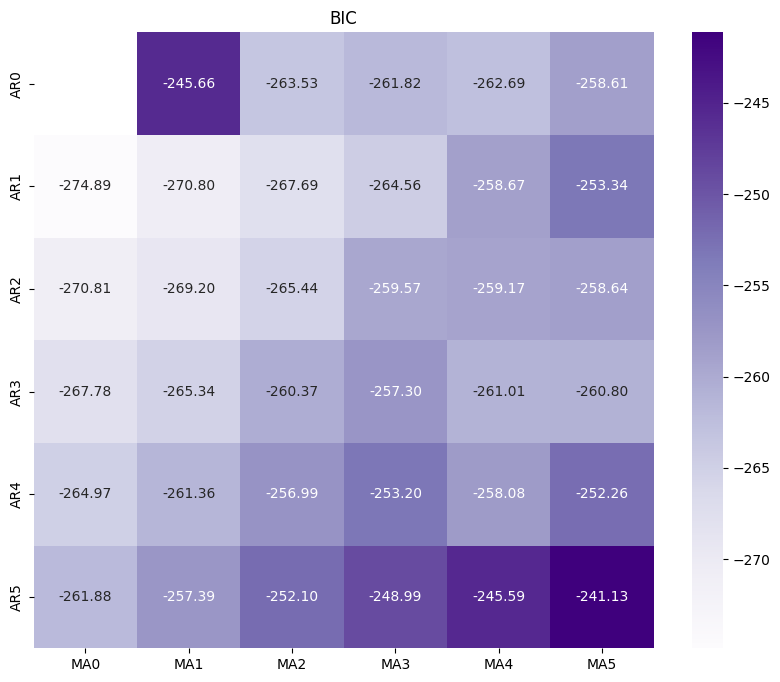

In [37]:
#绘制热力图
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 cmap="Purples"
                 )

ax.set_title('BIC')
plt.show()

In [38]:
results_bic.stack().idxmin()

('AR1', 'MA0')

# 利用模型取p和q的最优值

In [39]:
train_results = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='n', max_ar=8, max_ma=8)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

d:\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood opt

AIC (2, 1)
BIC (1, 0)


d:\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 模型检验

In [40]:
#根据以上求得
p = 1
d = 0
q = 0

In [41]:
model = sm.tsa.ARIMA(train, order=(p,d,q))
results = model.fit()
resid = results.resid #获取残差

d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


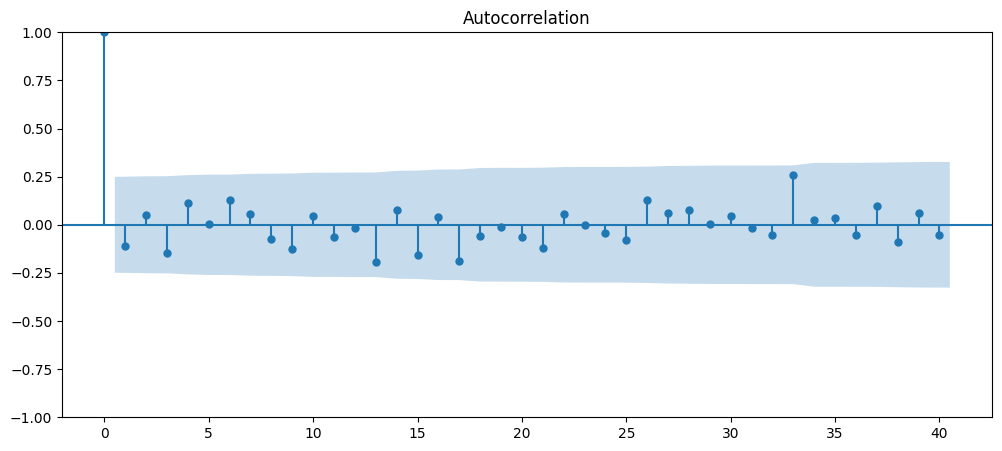

In [42]:
#绘制
#查看测试集的时间序列与数据(只包含测试集)
fig, ax = plt.subplots(figsize=(12, 5))

ax = sm.graphics.tsa.plot_acf(resid, lags=40,ax=ax)

plt.show()

# 模型预测

In [43]:
predict_sunspots = results.predict(dynamic=False)
print(predict_sunspots)

Date
2014-01-02    2.528206
2014-01-03    2.596990
2014-01-06    2.554943
2014-01-07    2.529715
2014-01-08    2.521305
                ...   
2014-03-25    2.538124
2014-03-26    2.538124
2014-03-27    2.538124
2014-03-28    2.554943
2014-03-31    2.571762
Name: predicted_mean, Length: 62, dtype: float64


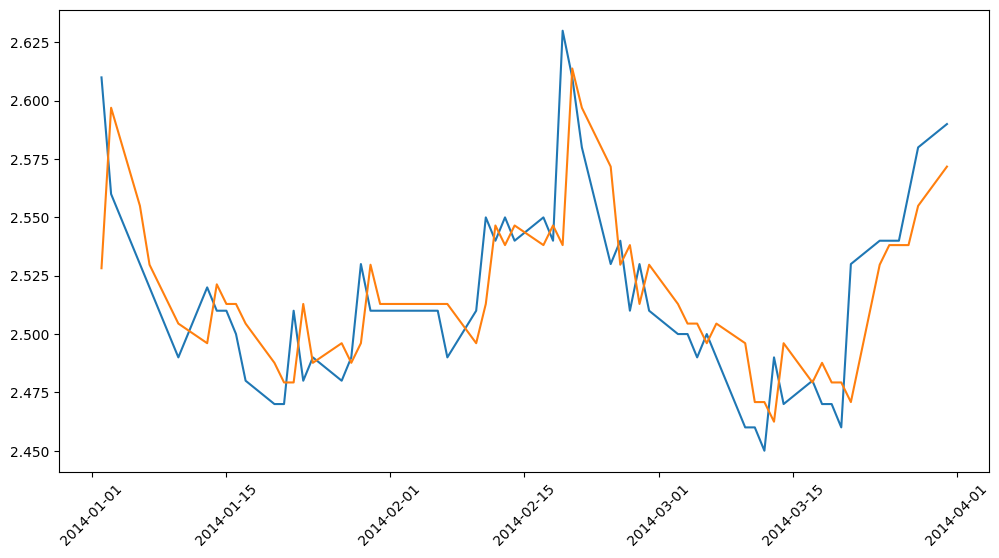

In [44]:
#查看测试集的时间序列与数据(只包含测试集)
plt.figure(figsize=(12,6))
plt.plot(train)
plt.xticks(rotation=45) #旋转45度
plt.plot(predict_sunspots)
plt.show()

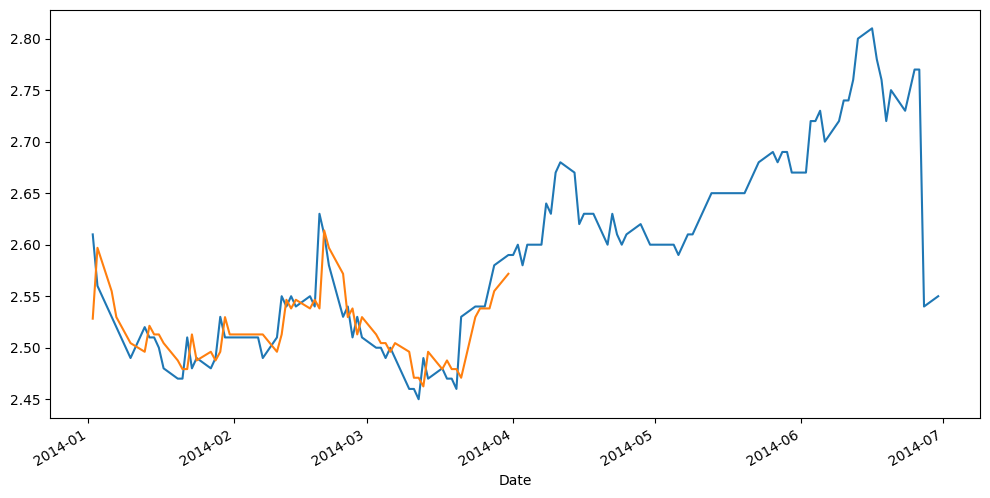

In [45]:
#绘图
fig, ax = plt.subplots(figsize=(12, 6))
ax = sub.plot(ax=ax)
#预测数据
predict_sunspots.plot(ax=ax)
plt.show()